In [1]:
from Bio.PDB import NeighborSearch, PDBParser, Selection, PDBIO
import pymol.cmd as cmd
import os
from IPython.display import display, Image
import matplotlib.pyplot as plt
import copy

In [2]:
# code to get nearby residues adapted from: 
# https://stackoverflow.com/questions/22476337/get-all-neighbors-of-a-set-of-residues

"""
chain = structure[0]['A']  # Supply chain name for "center residues"
center_residues = [chain[resi] for resi in [34]]
center_atoms = Selection.unfold_entities(center_residues, 'A')

atom_list = [atom for atom in structure.get_atoms()]
ns = NeighborSearch(atom_list)

# Set comprehension (Python 2.7+, use `set()` on a generator/list for < 2.7)
nearby_residues = {res for center_atom in center_atoms
                   for res in ns.search(center_atom.coord, 10, 'R')}

# Print just the residue number (WARNING: does not account for icodes)
nearby = sorted(res.id[1] for res in nearby_residues)
print(nearby)
"""

'\nchain = structure[0][\'A\']  # Supply chain name for "center residues"\ncenter_residues = [chain[resi] for resi in [34]]\ncenter_atoms = Selection.unfold_entities(center_residues, \'A\')\n\natom_list = [atom for atom in structure.get_atoms()]\nns = NeighborSearch(atom_list)\n\n# Set comprehension (Python 2.7+, use `set()` on a generator/list for < 2.7)\nnearby_residues = {res for center_atom in center_atoms\n                   for res in ns.search(center_atom.coord, 10, \'R\')}\n\n# Print just the residue number (WARNING: does not account for icodes)\nnearby = sorted(res.id[1] for res in nearby_residues)\nprint(nearby)\n'

In [3]:
def refine_structure(structure, output_path, cutoff, distance):
    # model = structure[0]
    model = copy.deepcopy(structure)[0]
    for chain in model:
        for residue in list(chain):
            residue_on_string = True
            center_atoms = Selection.unfold_entities([chain[residue.get_id()[1]]], 'A')
            atom_list = [atom for atom in structure.get_atoms()]
            ns = NeighborSearch(atom_list)
            nearby_residues = {res for center_atom in center_atoms for res in ns.search(center_atom.coord, distance, 'R')}
            nearby_residues = [res.id[1] for res in nearby_residues]

            for i in nearby_residues:
                if abs(i - residue.get_id()[1]) > cutoff:
                    residue_on_string = False
            if residue_on_string:
                chain.detach_child((' ', residue.get_id()[1], ' '))

    io=PDBIO()
    io.set_structure(model)
    io.save(output_path)
    
    return model

In [4]:
def generate_visualization(pdb_path, image_path, model_name):
    cmd.reinitialize()
    cmd.load(pdb_path, model_name)  # Use a unique model name
    cmd.hide("everything")
    cmd.show("cartoon")
    cmd.color("blue")
    cmd.set("ray_opaque_background", 0)
    cmd.png(image_path, ray=1)

In [5]:
cutoffs = [0, 1, 2, 3, 4, 5, 6, 7, 8]
distances = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
# Load initial PDB structure
structure = PDBParser().get_structure("AF-Q99P21-F1-model_v4", "AF-Q99P21-F1-model_v4.pdb")

for cutoff in cutoffs:
    for distance in distances:
        output_path = f"output_{cutoff}_{distance}.pdb"
        image_path = f"image_{cutoff}_{distance}.png"
        model_name = f"model_{cutoff}_{distance}"  # Unique name for each model
        refine_structure(structure, output_path, cutoff, distance)
        generate_visualization(output_path, image_path, model_name)

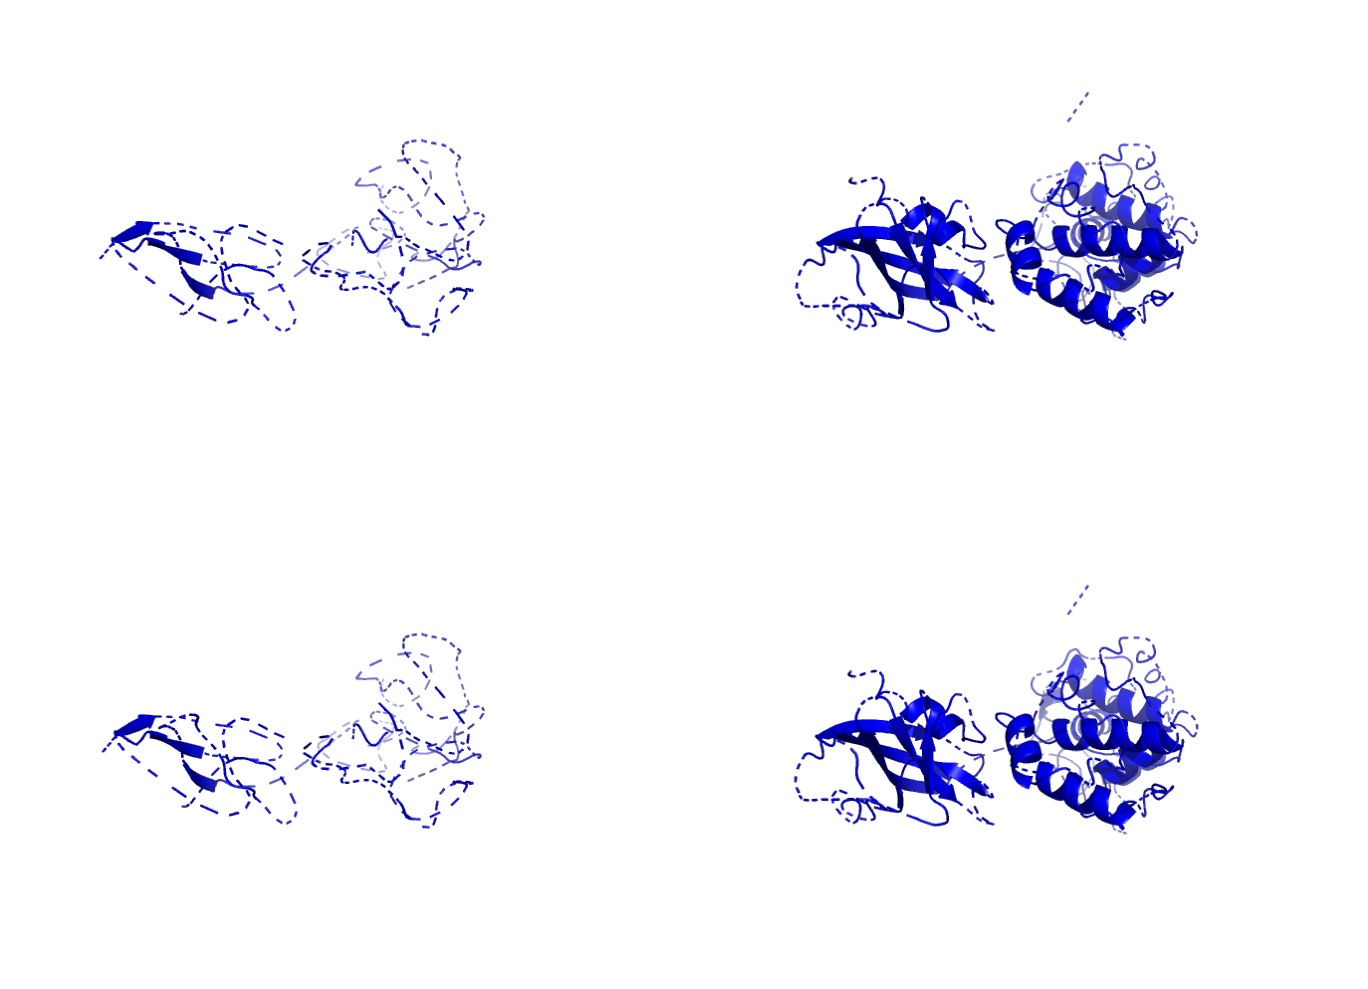

In [6]:
fig, axs = plt.subplots(len(cutoffs), len(distances), figsize=(15, 10))
for i, cutoff in enumerate(reversed(cutoffs)):
    for j, distance in enumerate(distances):
        img_path = f"image_{cutoff}_{distance}.png"
        img = plt.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
#         axs[i, j].set_title(f"Cutoff: {cutoff}, Distance: {distance}")

plt.tight_layout()
plt.show()